Importing

In [41]:
import torch
from torch.optim import Adam
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate # numerical integration tool for ode's

Physical System to Model: Spring, Mass, and Damper System

$ F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) = m\frac{d\mathbf{x^2}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(t) = ( F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) ) /m$

Text(0.5, 1.0, 'Numerical Solution to Spring, Mass, and Damper system')

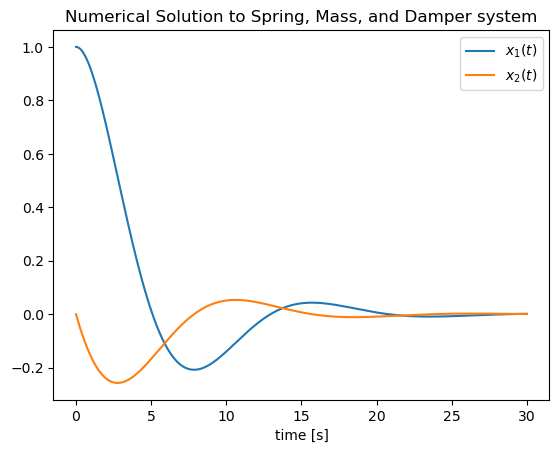

In [42]:
# Physical Parameters, c = damping constant, k =  stiffness of spring, m = mass, x0 = initial x, dx0dt = initial dxdt.
p = dict(c=4, k=2, m=10, F=0, x0=1, dx0dt=0)
p['d2x0dt2'] = (p['F'] - p['c']*p['dx0dt'] - p['k']*p['x0']) / p['m']
#initial conditions
x0 = [p['x0'],p['dx0dt']]
#plot to time T
T = 30

def f(x,t,p):
    x1, x2 = x[0], x[1]
    dx1 = x2
    dx2 = (p['F'] - p['c']*x2 - p['k']*x1) / p['m']
    return([dx1,dx2])

#Function to solve the physical system using numerical integration tool
def run_oscil(x0,T,p):
    t = np.linspace(0, T, 1000)
    dxdt = lambda x,t : f(x, t, p)
    x_t = integrate.odeint(dxdt, x0, t)
    return(t,x_t)

#Plotting neumerical solution
t_plot, x_plot = run_oscil(x0,T,p)
plt.plot(t_plot,x_plot)
plt.xlabel('time [s]')
#x_1 is position, x_2 is velocity
plt.legend(['$x_1(t)$','$x_2(t)$'])
plt.title("Numerical Solution to Spring, Mass, and Damper system")


The equation that models the Spring, Mass, and Damper System is the following:
$ F(t) = m\frac{d\mathbf{x^2}}{d t}(t) + c \frac{d\mathbf{x}}{d t}(t) + kx(t)$

The following parameters are needed to fully define the system:
1. Sum of Forces (F)
2. Mass (m)
3. Damping Constant (c)
4. Spring Stiffness (k)
5. Time (t)
6. Initial Conditions (x0)

These parameters can be used to determine the position (x) at current time (t).

Creating vectors for all parameters to be modelled

In [ ]:
# Range of t to be modelled [0,30]S
t_train = torch.linspace(0,30,64).view(-1,1)
# Ensure requires_grad = true in input tensor.
t_train.requires_grad_(True)

Defining the Model and Choosing Optimizer

In [44]:
# len i/o nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_len = 64

#params to take and approximate
params_in = 1
params_out = 1

model = nn.Sequential(
    nn.Linear(params_in, i_len),
    
    nn.Tanh(),
    nn.Linear(i_len, i_len),
    nn.Tanh(),
    nn.Linear(i_len, i_len),
    nn.Tanh(),

    nn.Linear(i_len, params_out)
    )

# choose optimizer
optim = Adam(model.parameters())    

Creating a custom loss function using the following:

Physics Loss:

$ F(t) - m\frac{d\mathbf{x^2}}{d t}(t) - c \frac{d\mathbf{x}}{d t}(t) - kx(t) = 0$

Initial Conditions Loss:

$x(0) = x_0$

$\frac{d\mathbf{x}}{d t}(0) = \frac{d\mathbf{x_0}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(0) = ( F(t) -c \frac{d\mathbf{x}}{d t}(0) - kx(0) ) /m$

In [45]:
def loss_fn(model, inputs):
    # model: model
    # inputs: vector with cols 0:t. Obtain other physical parameters from p dict.

    # Obtaining parameters to compute physics loss.
    x_pred = model(inputs)
    first_deriv = torch.autograd.grad(x_pred, inputs, torch.ones_like(x_pred), create_graph=True, retain_graph=True)[0]
    second_deriv = torch.autograd.grad(first_deriv, inputs, torch.ones_like(first_deriv), retain_graph=True)[0]

    dxdt_pred = first_deriv
    d2xdt2_pred = second_deriv
    F = p['F']
    m = p['m']
    c = p['c']
    k = p['k']

    # Calculate MSE loss based on physics governing eqns
    phy_loss = torch.mean( (F - m*d2xdt2_pred - c*dxdt_pred - k*x_pred)**2 )

    # Calulate loss from boundary conditions
    initial_input = torch.zeros(1, 1).requires_grad_(True)
    x0_pred = model(initial_input)
    dx0dt_pred = torch.autograd.grad(x0_pred, initial_input, torch.ones_like(x0_pred), create_graph=True, retain_graph=True)[0]
    d2x0dt2_pred = torch.autograd.grad(dx0dt_pred, initial_input, torch.ones_like(dx0dt_pred), retain_graph=True)[0]

    x0_loss = (x0_pred - p['x0'])**2
    dx0dt_loss = (dx0dt_pred - p['dx0dt'])**2
    d2x0dt2_loss = (d2x0dt2_pred - p['d2x0dt2'])**2
    i_loss = x0_loss + dx0dt_loss + d2x0dt2_loss

    loss = phy_loss + i_loss  

    return loss


Comparing plots of MLP approximation against numerical solution.

In [46]:
def plot_comp():
    # plotting numerical solution
    plt.plot(t_plot,x_plot[:,0],label='Numerical Solution')
    plt.xlabel('time [s]')
    plt.title(f"Comparing MLP Approximation and Numerical Solution, Epoch {epoch}, Loss {loss.item():.2E}")

    #creating tensors to be plotted
    plot_t = torch.from_numpy(t_plot).float().view(-1,1)
    pred = model(plot_t)
    pred_plot = torch.reshape(pred, (-1,)).detach().numpy()

    # plotting MLP approx
    plt.plot(t_plot,pred_plot,label='MLP Approximation')

    # plotting samples
    #t_train_plot = t_train.detach().numpy()
    #plt.plot(t_train_plot,np.zeros_like(t_train_plot),label='Samples',marker='+')

    plt.legend()
    plt.show()
    plt.clf()

Training the model

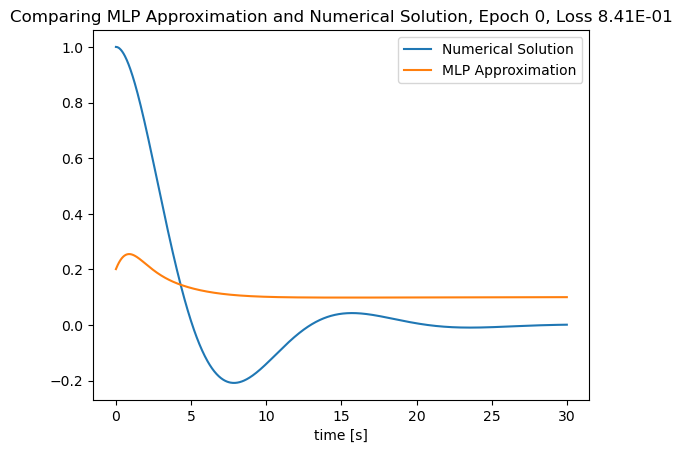

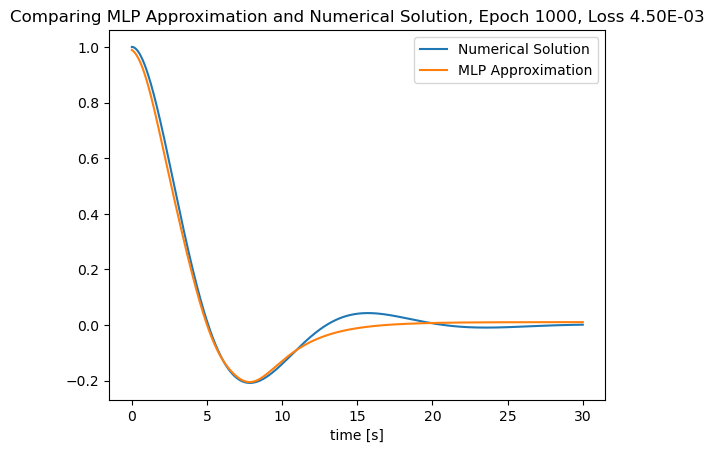

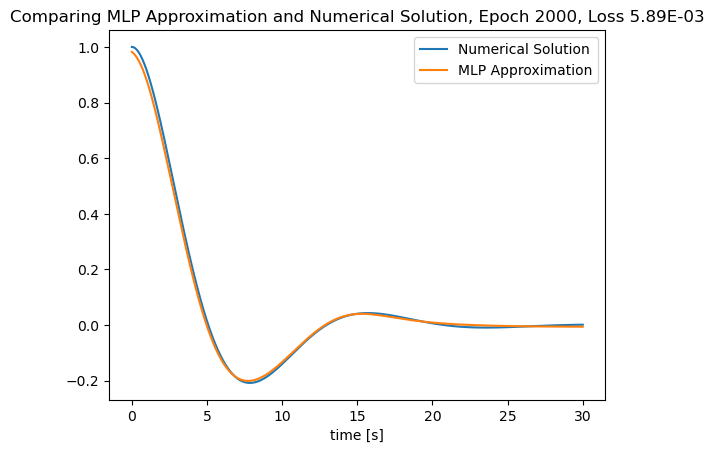

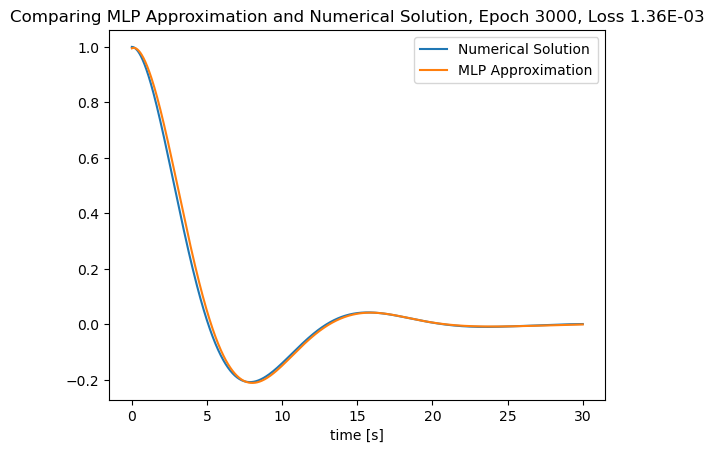

<Figure size 640x480 with 0 Axes>

In [47]:
#residuals? 
#loss balancing? ReLoBRaLo
#learning rate? REDUCELRONPLATEAU

n_epochs = 3001
batch_size = 32

for epoch in range(n_epochs):
    for b_num in range(0,len(t_train),batch_size):
        l = b_num
        u = l+batch_size
        batch = t_train[l:u,:]

        optim.zero_grad()
        loss = loss_fn(model, batch)
        loss.backward()
        optim.step()
    
    if not (epoch%1000):
        #print(f'Finished epoch {epoch}, latest loss {loss.item():.2E}')
        plot_comp()
